In [35]:
# -*- coding: utf-8 -*-
#  Copyright 2024 Till Leissner
#
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.
#
#   Authored by: Till Leissner (University of Southern Denmark)
#   Edited by: 
#
#   We acknowledge support from the ESS Lighthouse on Hard Materials in 3D, SOLID, funded by the Danish Agency for Science and Higher Education (grant No. 8144-00002B).

In [36]:
### General imports 
import os
import numpy as np
import glob
import matplotlib.pyplot as plt
#import json
import imageio

### Import all CIL components needed
import cil
from cil.framework import ImageData, ImageGeometry
from cil.plugins import tigre
from cil.io import TIFFWriter, TIFFStackReader
from cil.processors import CentreOfRotationCorrector, Binner, TransmissionAbsorptionConverter,RingRemover, Slicer
from cil.utilities.display import show2D, show_geometry

### Import custom helper functions
import bruker2cil as bc

# This notebook has been tested with CIL version 24.0.0
print(cil.__version__)

%load_ext autoreload

24.2.0
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Set variables and paths

To get started a few path variables have to be defined:

### Local storage 
For MinIo you can mount the bucket e.g. with 
- s3fs microct-data /mnt/minio -o url=https://app-nanosyd-till.cloud.sdu.dk -o use_path_request_style -o passwd_file=~.passwd-s3fs -o allow_other
- rclone mount Minio:microct-data /mnt/minio --vfs-cache-mode writes

In [ ]:
### Load log and info files with metadata of the scan
# Usually you do not need to change the following. 
datadir = './samples/02-switch-large' # Path to the dataset
dataset_prefix = '001' # Filename prefix
infofile = os.path.join(datadir,dataset_prefix+'.info') 
logfile = os.path.join(datadir,dataset_prefix+'.log') 
filelist = bc.get_filelist(datadir,dataset_prefix)
filelist

['./samples/02-switch-large/00100000000.tif',
 './samples/02-switch-large/00100000001.tif',
 './samples/02-switch-large/00100000002.tif',
 './samples/02-switch-large/00100000003.tif',
 './samples/02-switch-large/00100000004.tif',
 './samples/02-switch-large/00100000005.tif',
 './samples/02-switch-large/00100000006.tif',
 './samples/02-switch-large/00100000007.tif',
 './samples/02-switch-large/00100000008.tif',
 './samples/02-switch-large/00100000009.tif',
 './samples/02-switch-large/00100000010.tif',
 './samples/02-switch-large/00100000011.tif',
 './samples/02-switch-large/00100000012.tif',
 './samples/02-switch-large/00100000013.tif',
 './samples/02-switch-large/00100000014.tif',
 './samples/02-switch-large/00100000015.tif',
 './samples/02-switch-large/00100000016.tif',
 './samples/02-switch-large/00100000017.tif',
 './samples/02-switch-large/00100000018.tif',
 './samples/02-switch-large/00100000019.tif',
 './samples/02-switch-large/00100000020.tif',
 './samples/02-switch-large/001000

# Create acquisition geometry

The function *set_geometry* will parse the ".info" and the ".log" files, determine the scan parameters and create the corresponding CIL acquisition geometry.

In [38]:
ag = bc.set_geometry(logfile,infofile=infofile) # This will use the info file to determine the actually achieved projection angles
#ag = bc.set_geometry(logfile) # This will use the angular step size from the log file to determine the projection angles
#show_geometry(ag,grid=True)

# Read files

The helper function get_filelist will create a list of projection files. Further I check if the number of images corresponds to the number of angles obtained from the .info file. Afterwards the images are loaded using the CIL TIFFStackReader class.

In [39]:
filelist = bc.get_filelist(datadir,dataset_prefix)
if len(ag.angles) != len(filelist):
    print('Warning: Number of files does not correspond to number of rotational steps!')

In [40]:
reader = TIFFStackReader(file_name=filelist)

In [41]:
proj = reader.read_as_AcquisitionData(ag)

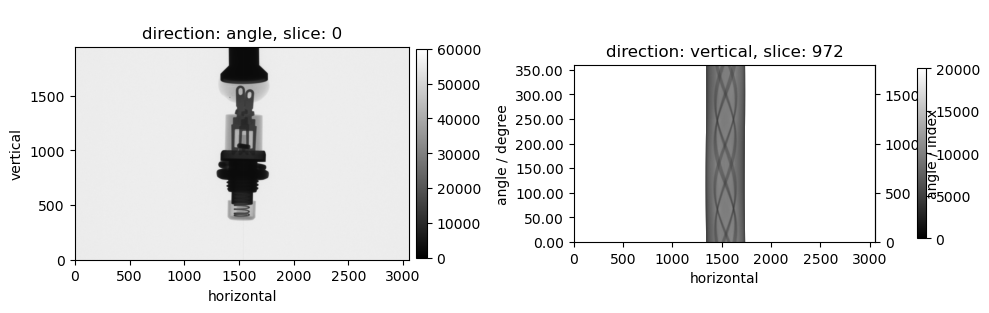

In [42]:
fig = show2D(proj, slice_list=[('angle',0),('vertical', np.floor_divide(proj.shape[1],2))], size=(10,10), num_cols=2, cmap="gray", fix_range=[(0,60000),(0,20000)])

## Align linear X/Y shift using reference images



[0] Angle 0.0°: Drift (y, x) = [0.02 0.01], error = 1.0
[1] Angle 26.6°: Drift (y, x) = [0.01 0.01], error = 1.0
[2] Angle 53.4°: Drift (y, x) = [0.01 0.01], error = 1.0
[3] Angle 80.0°: Drift (y, x) = [0. 0.], error = 1.0
[4] Angle 106.6°: Drift (y, x) = [0.01 0.  ], error = 1.0
[5] Angle 133.4°: Drift (y, x) = [ 0.01 -0.01], error = 1.0
[6] Angle 160.0°: Drift (y, x) = [ 0.01 -0.01], error = 1.0
[7] Angle 186.6°: Drift (y, x) = [ 0.   -0.01], error = 1.0
[8] Angle 213.4°: Drift (y, x) = [0. 0.], error = 1.0
[9] Angle 240.0°: Drift (y, x) = [0. 0.], error = 1.0
[10] Angle 266.6°: Drift (y, x) = [0. 0.], error = 1.0
[11] Angle 293.4°: Drift (y, x) = [0. 0.], error = 1.0
[12] Angle 320.0°: Drift (y, x) = [0. 0.], error = 1.0
[13] Angle 346.6°: Drift (y, x) = [0. 0.], error = 1.0


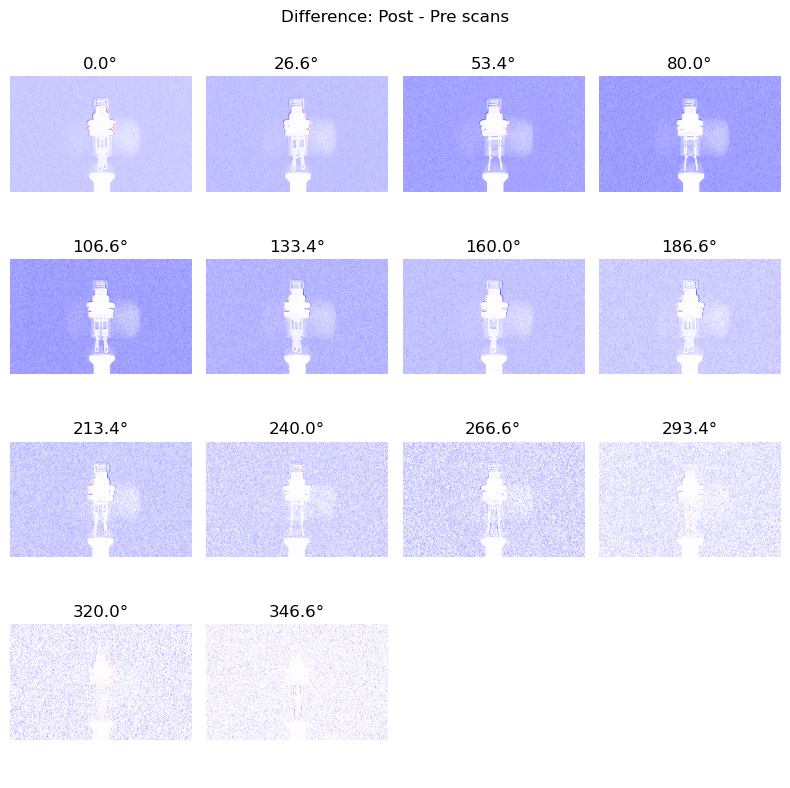

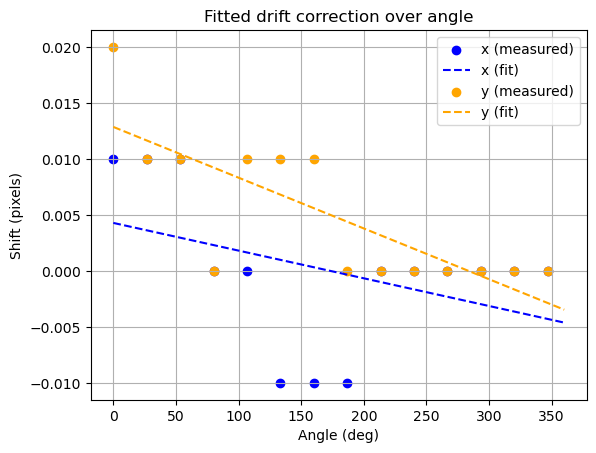

Start image alignment using 64 workers
Saved aligned image stack to '/home/till/dev/cil-import-bruker/samples/02-switch-large/aligned' with prefix 'aligned_'.


In [46]:
%autoreload 2
img_stack,_,_,_,_ = bc.align_projection_stack(
    proj,                         
    infofile,                     
    datadir,                      
    dataset_prefix,               
    filelist,                     
    "/home/till/dev/cil-import-bruker/samples/02-switch-large/aligned",                         # Directory to save shifted .tiff images
    output_prefix="aligned_",     # Prefix for saved .tiff images
    exact_match=False             # Match angles exactly or within half-step tolerance
)

#proj.fill(img_stack_shifted)